In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_json('./logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#check for null
df.isnull().sum()

login_time    0
dtype: int64

In [4]:
#resample: 15mins interval
df.set_index('login_time', inplace=True, drop=False)
df['count'] = 1
df = df.resample('15T').sum()
df['login_time'] = df.index

#extract year,month,week,day,hour,etc.
df['year'] = df['login_time'].dt.year
df['month'] = df['login_time'].dt.month
df['week'] = df['login_time'].dt.weekofyear
df['day'] = df['login_time'].dt.weekday
df['hour'] = df['login_time'].dt.hour
df['date'] = df['login_time'].dt.date
df['time'] = df['login_time'].dt.time

df.head()

,count,login_time,year,month,week,day,hour,date,time
login_time,,,,,,,,,
1970-01-01 20:00:00,2.0,1970-01-01 20:00:00,1970,1,1,3,20,1970-01-01,20:00:00
1970-01-01 20:15:00,6.0,1970-01-01 20:15:00,1970,1,1,3,20,1970-01-01,20:15:00
1970-01-01 20:30:00,9.0,1970-01-01 20:30:00,1970,1,1,3,20,1970-01-01,20:30:00
1970-01-01 20:45:00,7.0,1970-01-01 20:45:00,1970,1,1,3,20,1970-01-01,20:45:00
1970-01-01 21:00:00,1.0,1970-01-01 21:00:00,1970,1,1,3,21,1970-01-01,21:00:00


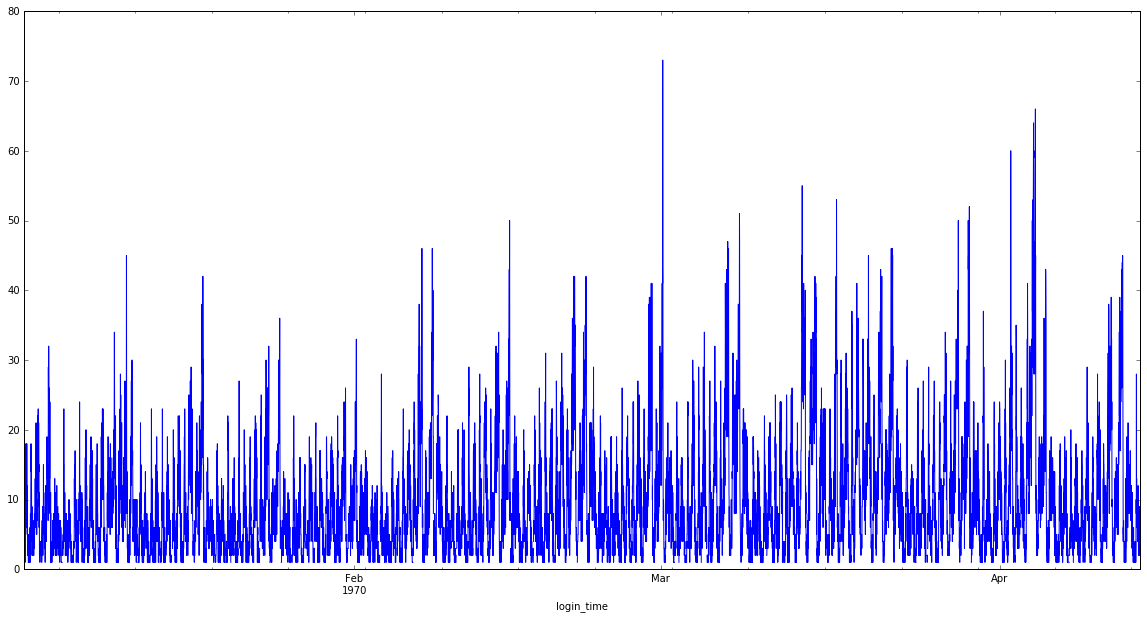

In [5]:
ts = pd.Series(df['count'],index=df.index)
plt.figure(figsize=(20,10))
ts.plot()

It's hard to see because of the darker area. Let's try and zoom in on a few days in January.

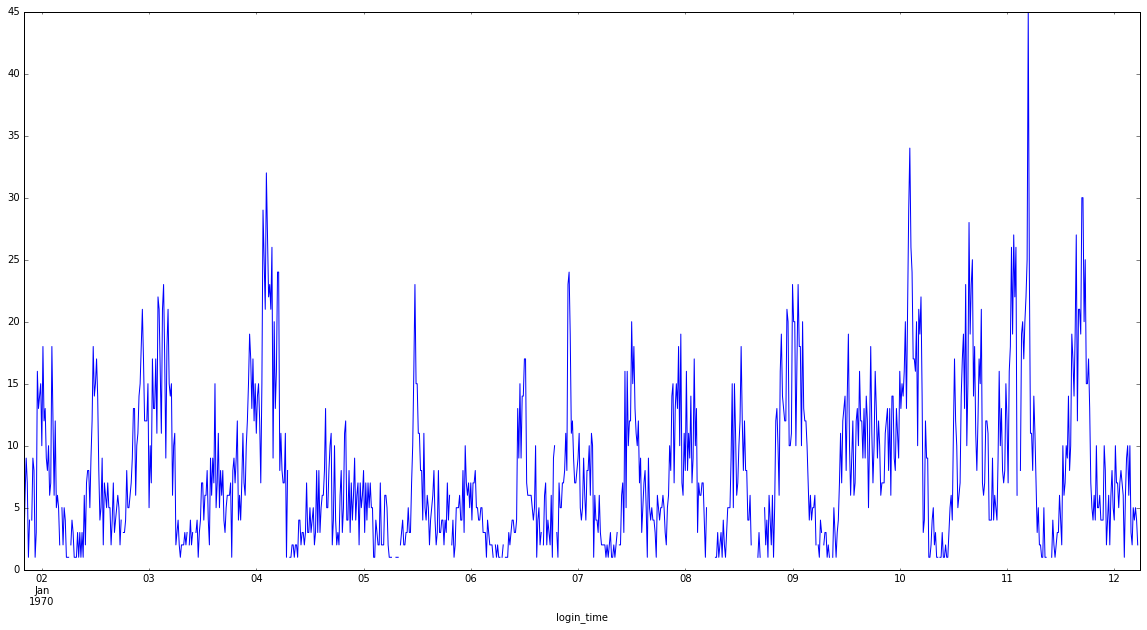

In [6]:
plt.figure(figsize=(20,10))
ts[0:1000].plot()

We can somehow see that the peak occurs every ~1/2day or ~12hrs.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


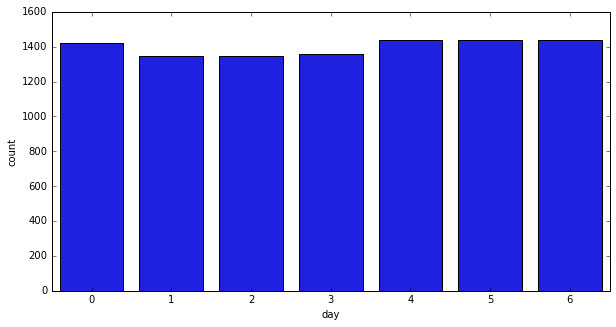

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x='day', data=df, color='blue')

Activity peaks on weekend.

(array([ 719171.,  719185.,  719199.,  719213.,  719227.,  719241.,  719255.]),
 <a list of 7 Text xticklabel objects>)

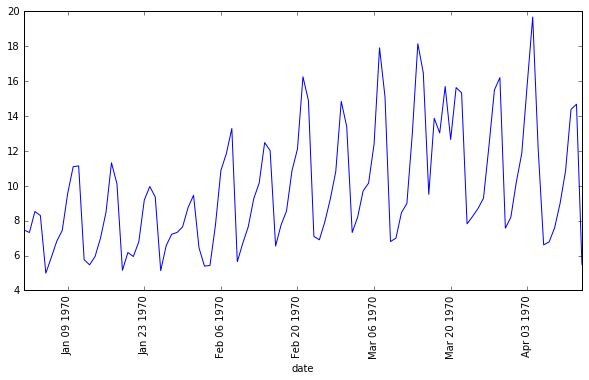

In [19]:
plt.figure(figsize=(10,5))
df.groupby('date').mean()['count'].plot()
plt.xticks(rotation='vertical')

(array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000.]), <a list of 10 Text xticklabel objects>)

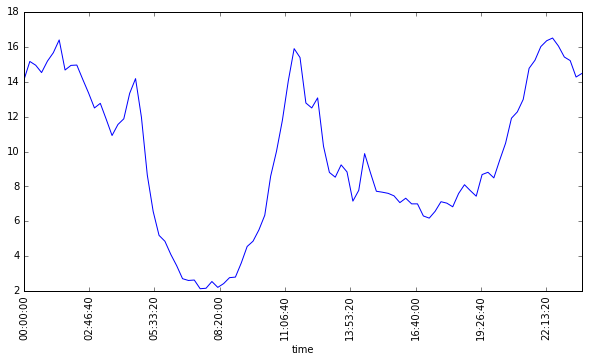

In [20]:
plt.figure(figsize=(10,5))
df.groupby('time')['count'].mean().plot()
plt.xticks(rotation='vertical')

Maximum activity is around 10pm-5am followed by 11AM-12PM. The user activity lowest at 6AM-9AM.

In [ ]:
df[df['count']==max(df['count'])]

The largest peak happens on Sunday in the early morning. Let's see whether this trend is consistent.

In [ ]:
day_of_week_max = []
hour_of_day_max = []
for x in range(int(len(ts)/96/7)):
    max_ = ts[96*7*x:(x+1)*96*7].max()
    day_of_week_max.append(ts[ts == max_].index[0].dayofweek)
    hour_of_day_max.append(ts[ts == max_].index[0].hour)
print('Peak happens on day:', day_of_week_max)
print('Peak happens on hour:', hour_of_day_max)

It's quite consistent that the peak happens on Sunday early morning for the first few weeks but at week 11 (mid March) the trend is not consistent anymore.

<b>Part One</b> <br>
Summary: There are two trends. The first is that the peaks approximately happens every ~12hrs in the early morning and early afternoon. The second is that activity builds over the course of the week, which peaks on weekend. The peak happens on Sunday early morning for the first few weeks but but at week 11 (mid March) the trend is not consistent anymore, eventhough there is still a lot of activity on weekend.

<b>Part Two: </b>
<br>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
<br><br>
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
<br>
One key measure that I would choose is weekend engagement for drivers (in city other than their primary weekday city). It is unlikely that drivers would take advantage of both cities as that means that drivers would have to work >12 hrs a day. However, for weekend, since it's active on both cities, it's more reasonable to expect drivers to take customers back and forth between the two cities without having to worry about the tolls.
<br><br>
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the observation
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
<br>
The first few weeks (as control), I would track drivers' city habits on both weekdays and weekends (which city are they spending most of their time in). Then, I would notify them of the new toll policy. Their trips for each city would be tracked. We need to note how many times the city location changes per day. Then, I would use t-test to compare the average number of trips back and forth and trips in nonweekday city. I would also compute an effect size because the number of trips may make it easy to find significance to find out if the difference is meaningful. If the the effect size is greater than certain value I would then compute an actual cost analysis to see if the cost of the program is outweighed by the extra money brought in. If both of these are true, the policy can be made permanent.

<b>Part Three</b>:

In [127]:
with open('./ultimate_data_challenge.json') as json_file:
    data = json.load(json_file)
users = pd.DataFrame(data)
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [128]:
#check for null values
users.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

There are a few null values in avg_rating_by_driver, avg_rating_of_driver, phone which is as expected. I would say that phone is not a useful feature but maybe we can setup a binary variable using phone variable. The nulls in ratings are going to be replaced with -1.

In [129]:
users['avg_rating_by_driver'].fillna(-1,inplace=True)
users['avg_rating_of_driver'].fillna(-1,inplace=True)

In [130]:
#create active users variable
active = []
for x in range(len(users)):
    start = pd.Timestamp(users['signup_date'][x]) #start date
    a = start + pd.Timedelta('181D') #6 months later
    b = a - pd.Timedelta('30D') #30 days prior
    if b <= pd.Timestamp(users['last_trip_date'][x]) <= a:
        active.append(1) 
    else:
        active.append(0)

users['active'] = active

In [131]:
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [132]:
#How many percent of users are active?
print('Percentage Active Users:',str(users.active.sum()/len(users.active)*100)+'%')

Percentage Active Users: 24.396%


In [133]:
#handling categorical data
users=users.join(pd.get_dummies(users.city,drop_first=True))
users=users.join(pd.get_dummies(users.phone,drop_first=True))
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,King's Landing,Winterfell,iPhone
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0,1,0,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,0,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,0,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,1,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,0,1,0


In [134]:
#train test split
from sklearn.model_selection import train_test_split, GridSearchCV
train,test = train_test_split(users,test_size=0.2)
print(train.shape)
print(test.shape)

(40000, 16)
(10000, 16)


In [136]:
#Light Gradient Boosting as the model
import lightgbm as lgb

features = [x for x in train.columns if x not in ['city','phone','active','last_trip_date','signup_date']]

#Create parameters to search
gridParams = {
    'learning_rate': [0.1,0.2,0.5],
    'num_leaves': [40,60,80,100],
    'max_depth':[4,6,8,10]
    }

#Create classifier to use
lgb_mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', objective = 'binary', metric = 'AUC')

#Create the grid
grid = GridSearchCV(lgb_mdl, gridParams, verbose=1, cv=3, n_jobs=-1)

#Run the grid
grid.fit(train[features], train['active'])

#best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   35.4s finished


{'learning_rate': 0.2, 'num_leaves': 40, 'max_depth': 8}
0.796025


In [138]:
#refit using best parameters
final_lgb_mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', objective = 'binary', metric = 'AUC',
                                  learning_rate = grid.best_params_['learning_rate'], 
                                  num_leaves = grid.best_params_['num_leaves'],
                                  max_depth = grid.best_params_['max_depth'])
final_lgb_mdl.fit(train[features], train['active'])

#predict
lgb_prediction = final_lgb_mdl.predict(test[features])

#measure performance
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
print(confusion_matrix(test['active'], lgb_prediction))
print(classification_report(test['active'], lgb_prediction))
print('AUC score:',roc_auc_score(test['active'], lgb_prediction))

[[7084  562]
 [1421  933]]
             precision    recall  f1-score   support

          0       0.83      0.93      0.88      7646
          1       0.62      0.40      0.48      2354

avg / total       0.78      0.80      0.78     10000

AUC score: 0.661422079525


//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

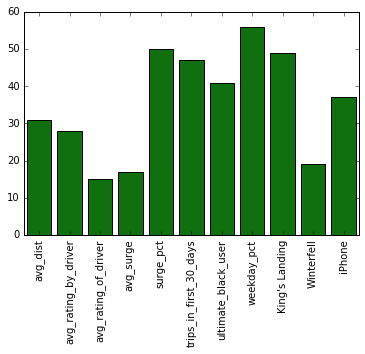

In [139]:
#plot feature importance
sns.barplot(features,final_lgb_mdl.feature_importances_,color='green')
plt.xticks(rotation='vertical')

Summary: First we need to determine the number of active users, which is 24%. Then, build a model to do a binary classification of active users. The model used is light gradient boosting model since lgbm is considered one of the fastest and most accurate model to do binary classification (the model is often used in kaggle competition). The final model has an AUC of 0.66. The most important feature is weekday_pct, followed by King's Landing binary, surge_pct, trips_in_first_30_days, and so on. The company should prioritize to work/do campaign around features based on their relative importance.